<a href="https://colab.research.google.com/github/dream2hvn/MachineLearning/blob/main/Grape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import library

In [1]:
# Import the required library
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
import random
import tensorflow as tf
import numpy as np
import seaborn as sns
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from PIL import Image, ImageDraw, ImageOps

2. Download Dataset

In [2]:
!chmod 600 /content/kaggle.json

In [3]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download muhammadraihanf12/agricurify-grape

Dataset URL: https://www.kaggle.com/datasets/muhammadraihanf12/agricurify-grape
License(s): unknown
agricurify-grape.zip: Skipping, found more recently modified local copy (use --force to force download)


3. Dataset Extraction

In [4]:
import zipfile

# ZIP file location
zip_file_path = "/content/agricurify-grape.zip"
extract_to_path = "/content/"

# Extracting ZIP files
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
        print("Files are successfully extracted to the directory:", extract_to_path)
else:
    print("The ZIP file was not found in the location:", zip_file_path)

Files are successfully extracted to the directory: /content/


4. Dataset Analysis & Merged

In [5]:
# List of dataset directories
dataset_dirs = [
    "/content/Grape___Black_rot",
    "/content/Grape___Esca_(Black_Measles)",
    "/content/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "/content/Grape___healthy",
    "/content/Non___Grape"
]

# Destination directory for merged datasets
merged_dataset_dir = "/content/Merged_Grape"

# Create a destination directory if it doesn't already exist
os.makedirs(merged_dataset_dir, exist_ok=True)

# Copy images from each dataset directory to the destination directory, preserving the class structure
for dataset_dir in dataset_dirs:
    # Get class name from directory name
    class_name = os.path.basename(dataset_dir)

    # Create a class sub-directory in the destination directory if it doesn't already exist
    target_class_dir = os.path.join(merged_dataset_dir, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    # Copy images from the dataset directory to the class sub-directory in the destination directory
    for filename in os.listdir(dataset_dir):
        src_path = os.path.join(dataset_dir, filename)
        dst_path = os.path.join(target_class_dir, filename)
        shutil.copy(src_path, dst_path)

print("The dataset has been merged to:", merged_dataset_dir)

The dataset has been merged to: /content/Merged_Grape


In [6]:
grape_data = "/content/Merged_Grape"
grape_classes = os.listdir(grape_data)

print("grape_classes:")
for classes in grape_classes:
    if os.path.isdir(os.path.join(grape_data, classes)):
        print(classes)

grape_classes:
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___Black_rot
Non___Grape
Grape___Esca_(Black_Measles)
Grape___healthy



Class Name: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Total Images: 5351
Resolution of First Image: (256, 256, 3)


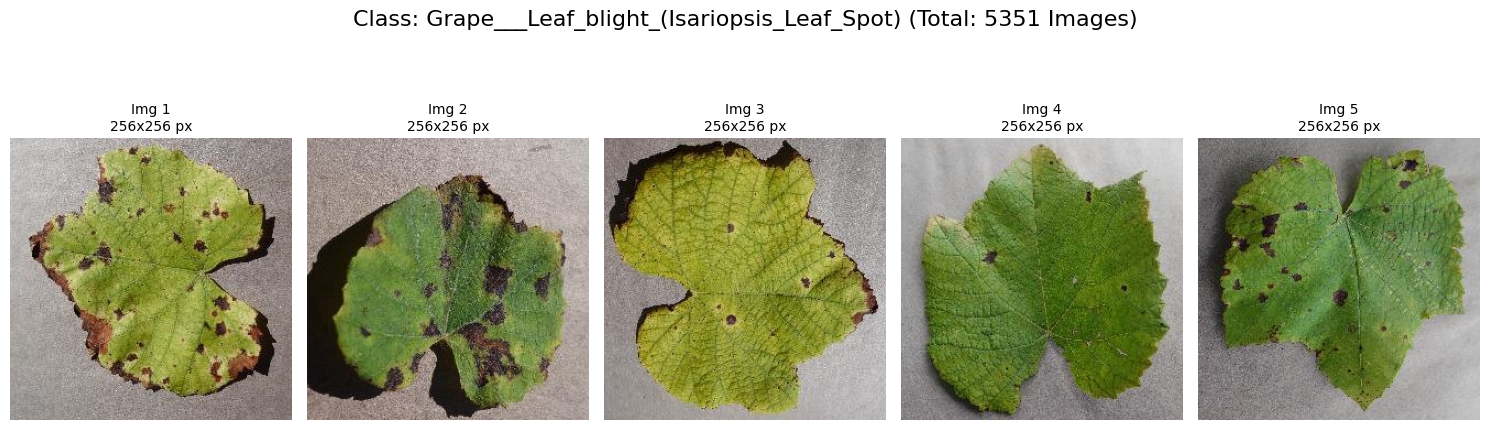


Class Name: Grape___Black_rot
Total Images: 5445
Resolution of First Image: (256, 256, 3)


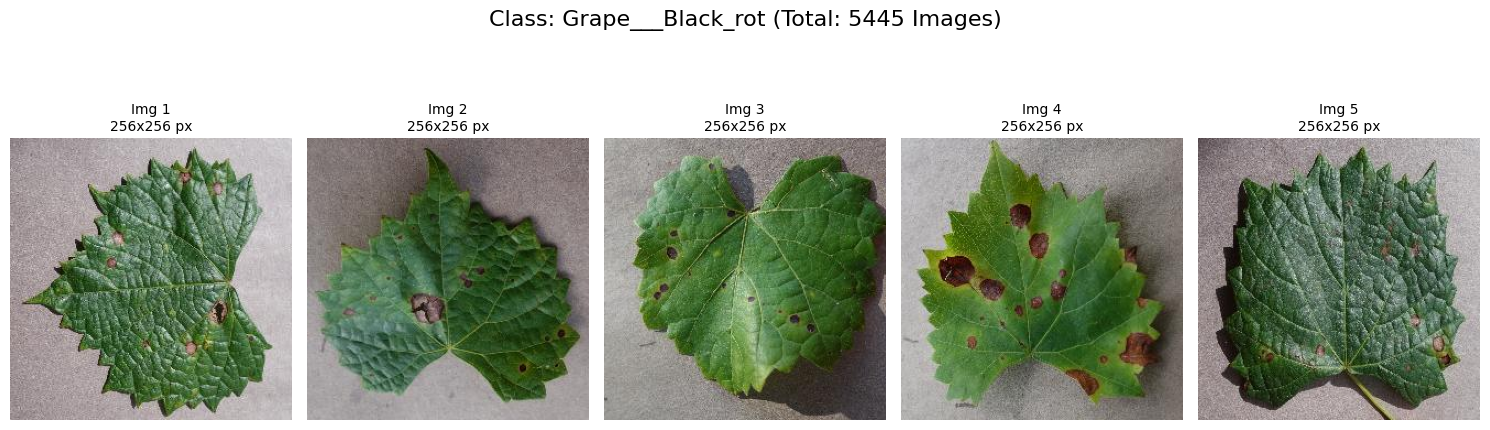


Class Name: Non___Grape
Total Images: 5047
Resolution of First Image: (255, 139, 3)


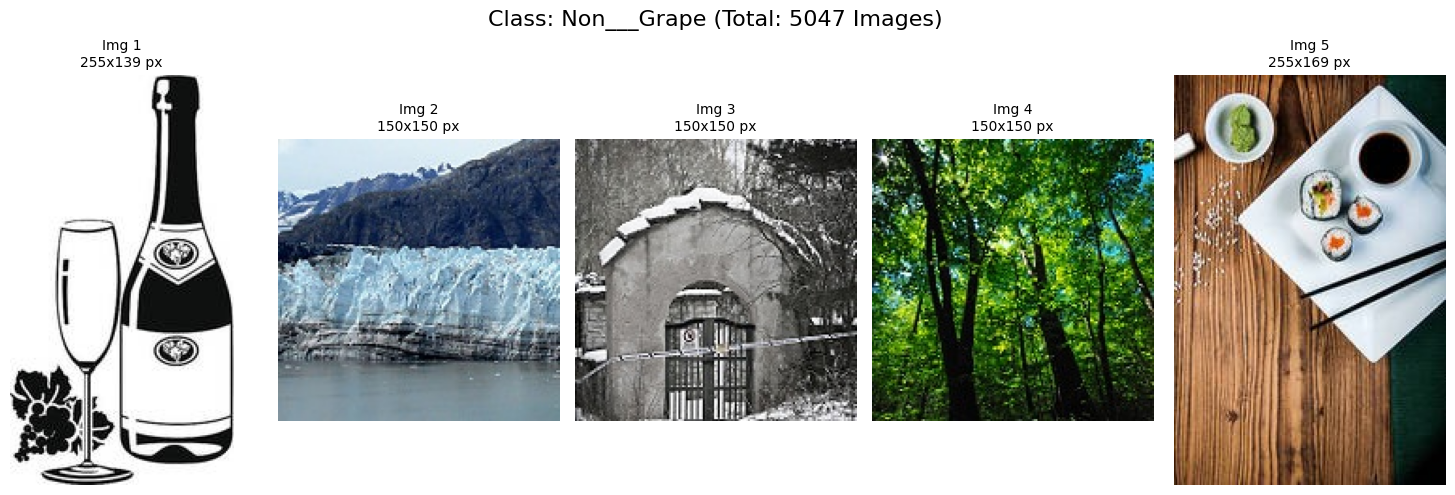


Class Name: Grape___Esca_(Black_Measles)
Total Images: 5185
Resolution of First Image: (256, 256, 3)


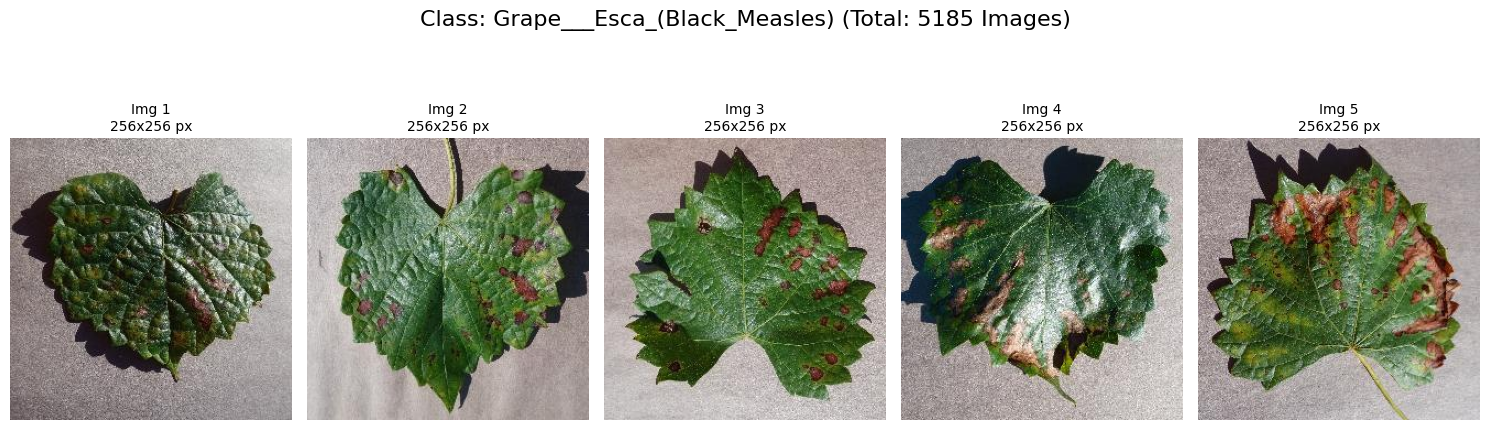


Class Name: Grape___healthy
Total Images: 5111
Resolution of First Image: (256, 256, 3)


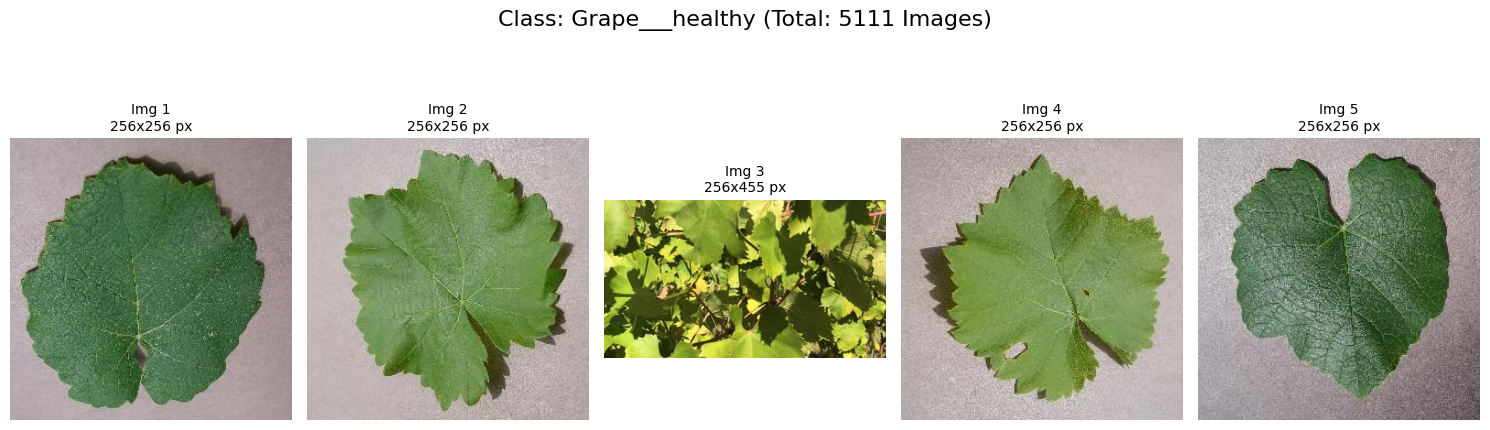

In [7]:
for item in grape_classes:
    print("\nClass Name:", item)
    class_dir = os.path.join(grape_data, item)
    class_images = os.listdir(class_dir)

    # Total images in each class
    num_images = len(class_images)
    print("Total Images:", num_images)

    # Resolution/size of the first image in the class
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolution of First Image:", image_shape)

    # Displaying some images with descriptive labels
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Class: {item} (Total: {num_images} Images)", fontsize=16)

    for i, img_file in enumerate(class_images[:5]):  # Display up to 5 images
        img_path = os.path.join(class_dir, img_file)
        img = mpimg.imread(img_path)

        # Add a subplot for each image
        sp = plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.imshow(img)

        # Add descriptive title to each image
        plt.title(f"Img {i+1}\n{img.shape[0]}x{img.shape[1]} px", fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust to fit the suptitle
    plt.show()

5. Data Preprocesing

In [8]:
# New Directory for Balanced and Finalizing Dataset
Final_data_dir = "/content/Final_data"

# Number of Images to Be Selected from Each Class
num_images_per_class = min(len(os.listdir(os.path.join(grape_data, "Grape___Esca_(Black_Measles)"))),
                           len(os.listdir(os.path.join(grape_data, "Grape___Black_rot"))),
                           len(os.listdir(os.path.join(grape_data, "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)"))),
                           len(os.listdir(os.path.join(grape_data, "Grape___healthy"))),
                           len(os.listdir(os.path.join(grape_data, "Non___Grape"))))

# Create New Directory in Final_data_dir
for class_name in grape_classes:
    os.makedirs(os.path.join(Final_data_dir, class_name), exist_ok=True)

# Select Some Images from Each Class and Copy to Final_data_dir
for class_name in grape_classes:
    source_dir = os.path.join(grape_data, class_name)
    destination_dir = os.path.join(Final_data_dir, class_name)

    # Get a list of image files in the source directory
    image_files = os.listdir(source_dir)

    # Select a subset of images (up to num_images_per_class)
    selected_images = image_files[:num_images_per_class]

    # Copy the selected images to the destination directory
    for image_file in selected_images:
        shutil.copy(os.path.join(source_dir, image_file), destination_dir)

print(f"Final_data dataset created in: {Final_data_dir}")

Final_data dataset created in: /content/Final_data


Preview Final Dataset:

Kelas: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Total Gambar: 5047


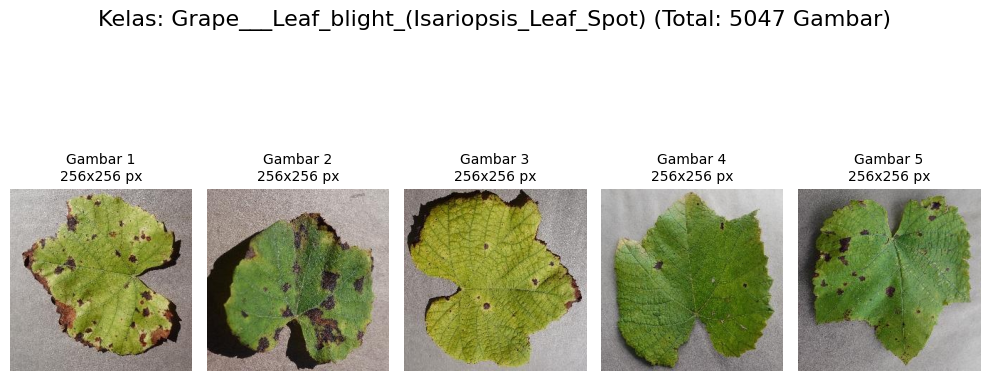


Kelas: Grape___Black_rot
Total Gambar: 5047


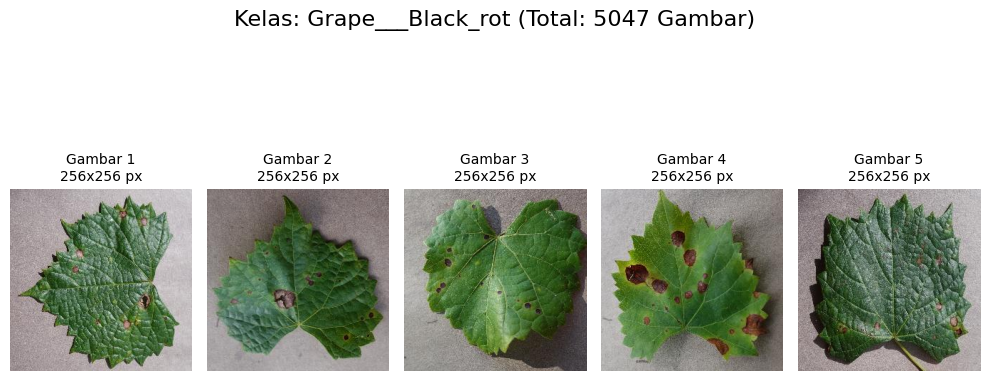


Kelas: Non___Grape
Total Gambar: 5047


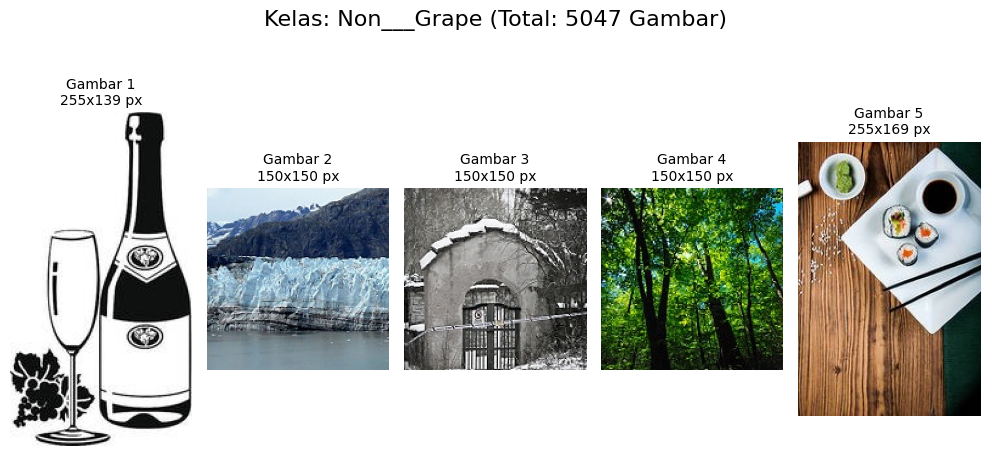


Kelas: Grape___Esca_(Black_Measles)
Total Gambar: 5047


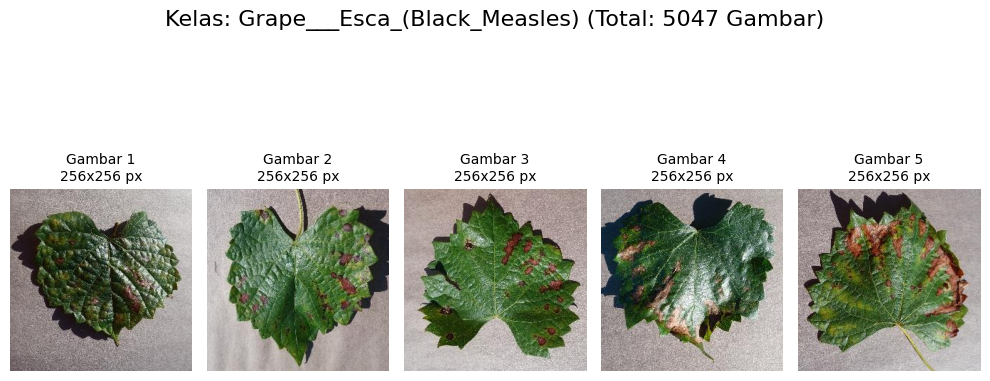


Kelas: Grape___healthy
Total Gambar: 5047


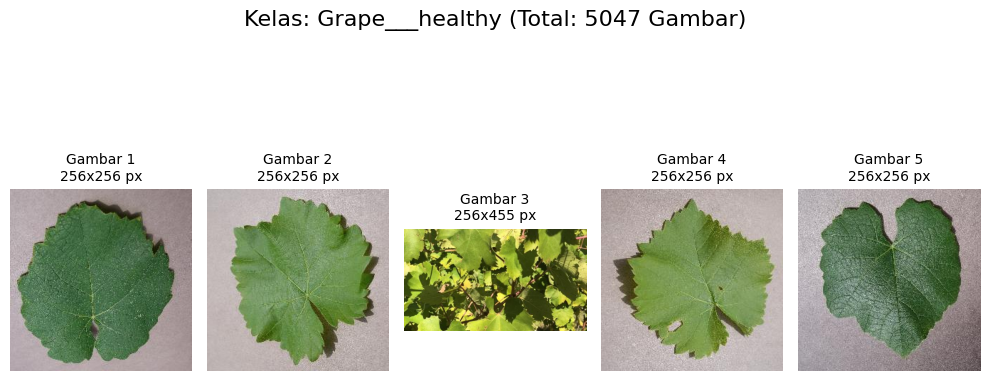

In [9]:
# Preview from Final dataset
print("Preview Final Dataset:")

for class_name in grape_classes:
    print(f"\nKelas: {class_name}")

    # Directory class
    class_dir = os.path.join(Final_data_dir, class_name)

    # Classroom picture list
    class_images = os.listdir(class_dir)

    # Total pictures in class
    num_images = len(class_images)
    print(f"Total Gambar: {num_images}")

    # Display some images from the class
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Kelas: {class_name} (Total: {num_images} Gambar)", fontsize=16)

    for i, image_file in enumerate(class_images[:5]):  # Display up to 5 images
        image_path = os.path.join(class_dir, image_file)
        image = mpimg.imread(image_path)

        # Add subplots for each image
        plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.imshow(image)

        # Added descriptive titles to each image
        plt.title(f"Gambar {i + 1}\n{image.shape[0]}x{image.shape[1]} px", fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Add descriptive title to faithful
    plt.show()

6. Split Model

In [10]:
# Dataset directory and class names
dataset_dir = "/content/Final_data"
classes = [
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Non___Grape"
]

# Ratios for splitting data
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Process each class
for class_name in classes:
    # Define class directory and fetch files
    class_dir = os.path.join(dataset_dir, class_name)
    files = os.listdir(class_dir)
    random.shuffle(files)

    # Calculate split sizes
    num_files = len(files)

    # Ensure there are enough files for each split
    if num_files < 3:
        print(f"Not enough files in {class_name} to split into train, val, and test sets.")
        continue

    num_train = max(1, int(num_files * train_ratio))
    num_val = max(1, int(num_files * val_ratio))
    num_test = num_files - num_train - num_val

    # Adjust if necessary to ensure all splits are non-empty
    if num_test < 1:
        num_test = 1
        num_val = num_files - num_train - num_test

    if num_val < 1:
        num_val = 1
        num_test = num_files - num_train - num_val

    # Split files into train, validation, and test sets
    train_files = files[:num_train]
    val_files = files[num_train:num_train + num_val]
    test_files = files[num_train + num_val:]

    # Move files to respective folders
    for folder_name, file_list in [("train", train_files), ("val", val_files), ("test", test_files)]:
        folder_path = os.path.join(dataset_dir, folder_name, class_name)
        os.makedirs(folder_path, exist_ok=True)

        for file in file_list:
            src = os.path.join(class_dir, file)
            dst = os.path.join(folder_path, file)
            shutil.move(src, dst)

In [11]:
# Directory paths
train_dir = '/content/Final_data/train'
val_dir = '/content/Final_data/val'
test_dir = '/content/Final_data/test'

# Image size that matches the MobileNetV2 input
img_size = 224
batch_size = 32

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Using flow_from_directory to read images from a directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')



Found 24247 images belonging to 5 classes.
Found 4800 images belonging to 5 classes.
Found 4821 images belonging to 5 classes.


7. Create a Model


In [12]:
# Pre-trained MobileNetV2 model initialization
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze layers MobileNetV2
base_model.trainable = False

# Modeling with additional custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes for grape
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,916,421 (11.13 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

8. Initial Training

In [13]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=2
)

# Evaluation model data val
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc * 100:.2f}%')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


758/758 - 347s - 457ms/step - accuracy: 0.9479 - loss: 0.1426 - val_accuracy: 0.9719 - val_loss: 0.0764
Epoch 2/10
758/758 - 362s - 478ms/step - accuracy: 0.9668 - loss: 0.0896 - val_accuracy: 0.9806 - val_loss: 0.0555
Epoch 3/10
758/758 - 323s - 426ms/step - accuracy: 0.9714 - loss: 0.0760 - val_accuracy: 0.9677 - val_loss: 0.0701
Epoch 4/10
758/758 - 385s - 508ms/step - accuracy: 0.9736 - loss: 0.0720 - val_accuracy: 0.9823 - val_loss: 0.0480
Epoch 5/10
758/758 - 324s - 428ms/step - accuracy: 0.9756 - loss: 0.0662 - val_accuracy: 0.9827 - val_loss: 0.0448
Epoch 6/10
758/758 - 379s - 500ms/step - accuracy: 0.9762 - loss: 0.0661 - val_accuracy: 0.9831 - val_loss: 0.0429
Epoch 7/10
758/758 - 321s - 423ms/step - accuracy: 0.9783 - loss: 0.0595 - val_accuracy: 0.9867 - val_loss: 0.0379
Epoch 8/10
758/758 - 325s - 429ms/step - accuracy: 0.9801 - loss: 0.0557 - val_accuracy: 0.9831 - val_loss: 0.0428
Epoch 9/10
758/758 - 381s - 502ms/step - accuracy: 0.9794 - loss: 0.0563 - val_accuracy: 0.

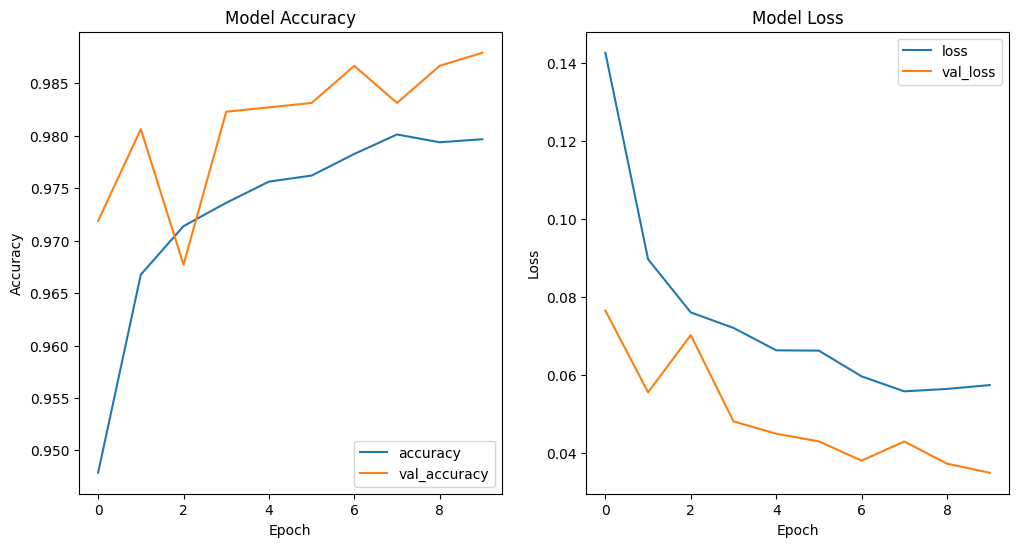

In [14]:
# Plotting accuracy and loss Initial Training
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


Found 4821 images belonging to 5 classes.
151/151 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step


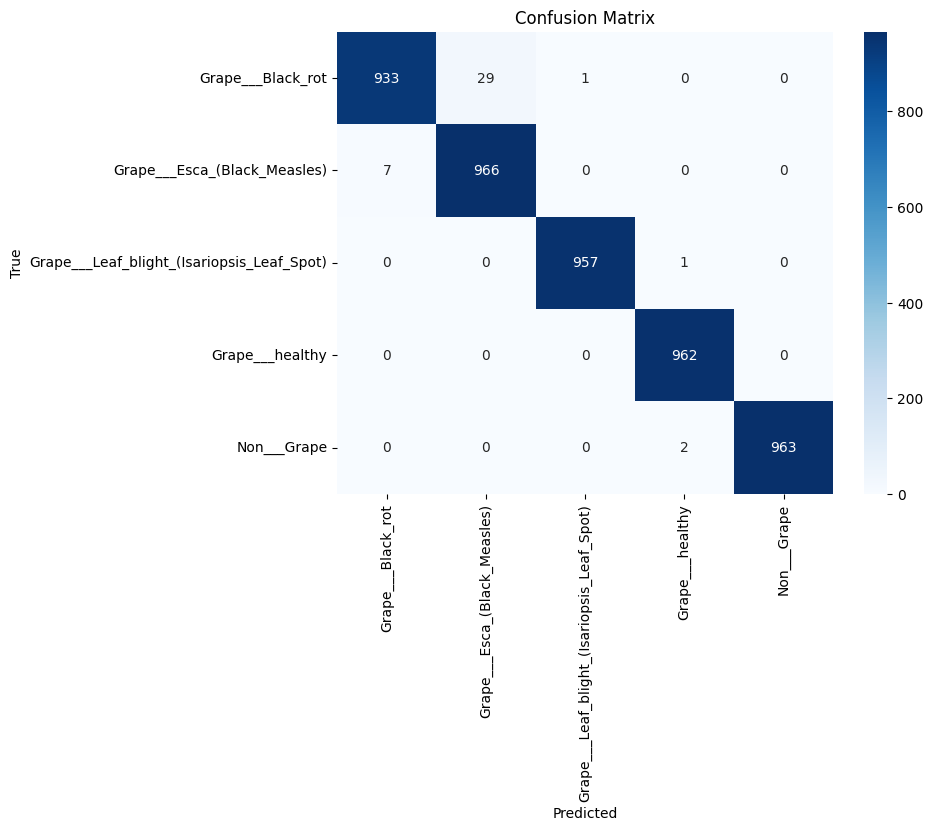

In [15]:
# Confusion Matrix (for data testing) Initial Training
test_generator = val_datagen.flow_from_directory(test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical', shuffle=False)

# Prediction with trained model
test_preds = model.predict(test_generator, verbose=1)
test_preds = np.argmax(test_preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

9. Fine Tuning

In [16]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training the model with the same data
history_fine_tuning = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=2
)

Epoch 1/10
758/758 - 351s - 463ms/step - accuracy: 0.8651 - loss: 1.9009 - val_accuracy: 0.9860 - val_loss: 0.0346
Epoch 2/10
758/758 - 368s - 485ms/step - accuracy: 0.9678 - loss: 0.0976 - val_accuracy: 0.9852 - val_loss: 0.0346
Epoch 3/10
758/758 - 328s - 432ms/step - accuracy: 0.9740 - loss: 0.0744 - val_accuracy: 0.9902 - val_loss: 0.0291
Epoch 4/10
758/758 - 347s - 457ms/step - accuracy: 0.9801 - loss: 0.0557 - val_accuracy: 0.9869 - val_loss: 0.0298
Epoch 5/10
758/758 - 373s - 492ms/step - accuracy: 0.9821 - loss: 0.0494 - val_accuracy: 0.9921 - val_loss: 0.0230
Epoch 6/10
758/758 - 344s - 454ms/step - accuracy: 0.9856 - loss: 0.0410 - val_accuracy: 0.9902 - val_loss: 0.0246
Epoch 7/10
758/758 - 378s - 498ms/step - accuracy: 0.9881 - loss: 0.0350 - val_accuracy: 0.9942 - val_loss: 0.0175
Epoch 8/10
758/758 - 372s - 490ms/step - accuracy: 0.9887 - loss: 0.0320 - val_accuracy: 0.9937 - val_loss: 0.0180
Epoch 9/10
758/758 - 384s - 507ms/step - accuracy: 0.9900 - loss: 0.0303 - val_a

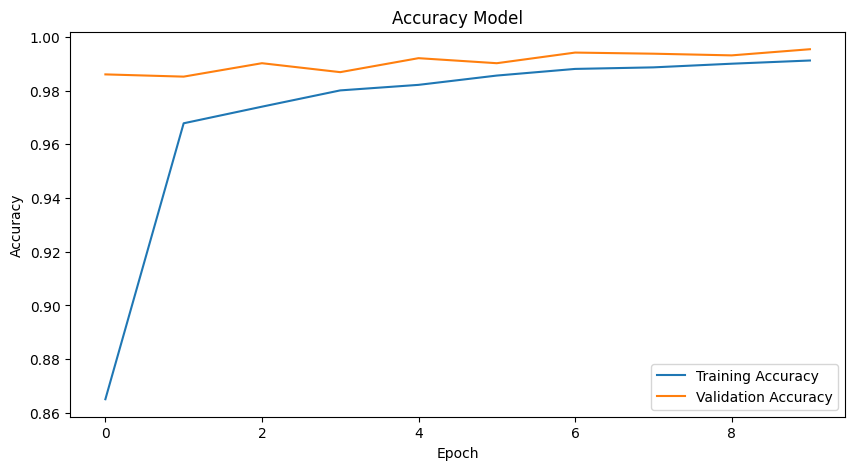

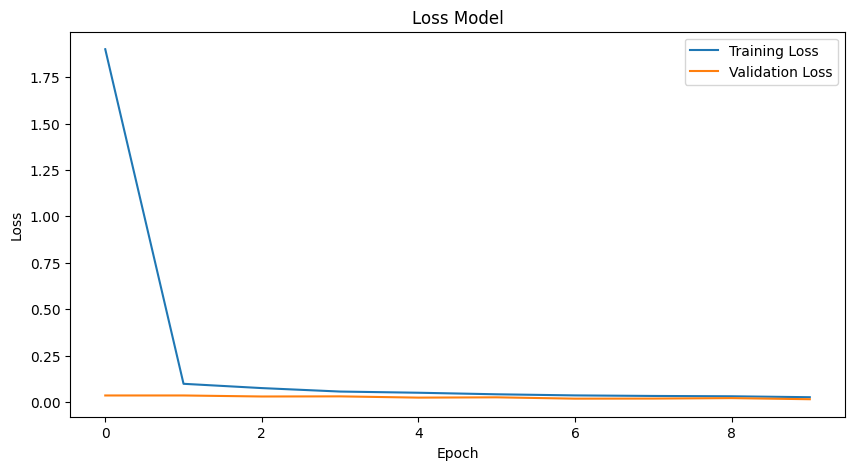

In [17]:
# Plot Accuracy after fine tuning
plt.figure(figsize=(10, 5))
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_fine_tuning.history['loss'], label='Training Loss')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step


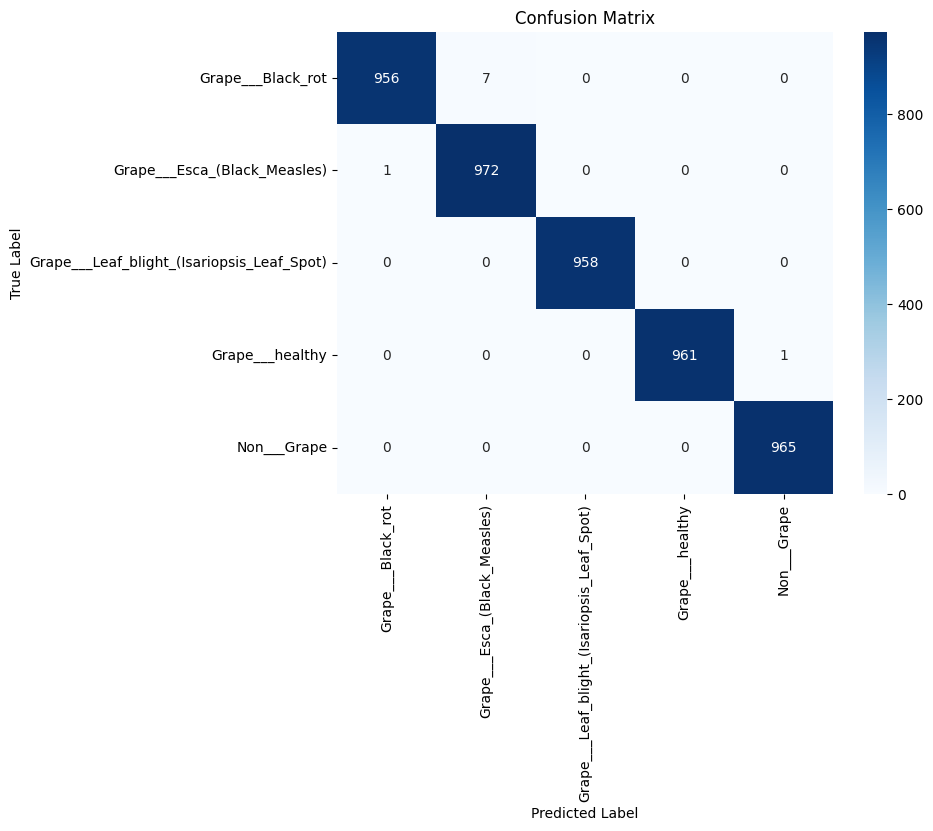

In [18]:
# Prediction on test data
test_predictions = model.predict(test_generator, verbose=1)
test_predictions = np.argmax(test_predictions, axis=1)  # Get predicted class labels

# Get true labels from the test generator
true_labels = test_generator.classes

# Create confusion matrix after fine tuning
cm = confusion_matrix(true_labels, test_predictions)

# Visualization of confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

9. Test Model With Data Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


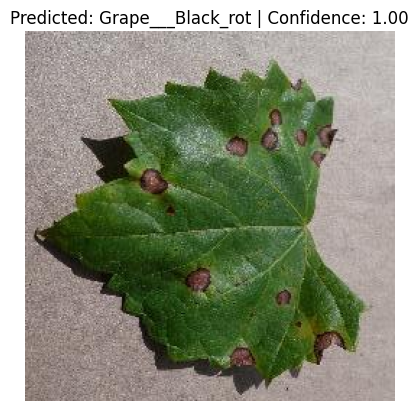

In [22]:
from tensorflow.keras.preprocessing import image

# Function for image prediction
def predict_image(img_path, model, img_size):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add dimension for batch size
    img_array /= 255.0  # Normalization
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction)  # Predicted class
    confidence = prediction[0][pred_class]
    return pred_class, confidence

# Function to display images and prediction results
def display_image_and_prediction(img_path, pred_class, confidence, class_names):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[pred_class]} | Confidence: {confidence:.2f}')
    plt.show()

# Make a predict
img_path = '/content/Final_data/test/Grape___Black_rot/Grape_Black_rot1007.jpg'
pred_class, confidence = predict_image(img_path, model, img_size)

# List of class names in the model
class_names = list(test_generator.class_indices.keys())

# Display images and prediction results
display_image_and_prediction(img_path, pred_class, confidence, class_names)


10. Test Model With New Image Out Of Dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


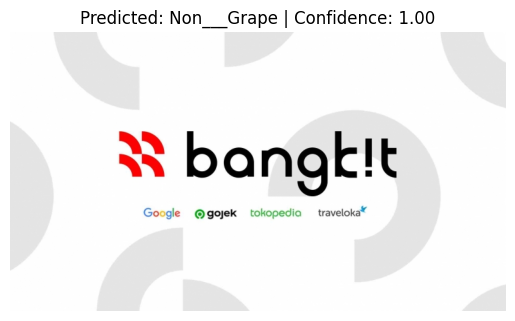

In [23]:
from tensorflow.keras.preprocessing import image

# Function for image prediction
def predict_image(img_path, model, img_size):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add dimension for batch size
    img_array /= 255.0  # Normalization
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction)  # Predicted class
    confidence = prediction[0][pred_class]
    return pred_class, confidence

# Function to display images and prediction results
def display_image_and_prediction(img_path, pred_class, confidence, class_names):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[pred_class]} | Confidence: {confidence:.2f}')
    plt.show()

# Make a predict
img_path = '/content/program-bangkit-659a5439de948f7dd9389922.jpeg'
pred_class, confidence = predict_image(img_path, model, img_size)

# List of class names in the model
class_names = list(test_generator.class_indices.keys())

# Display images and prediction results
display_image_and_prediction(img_path, pred_class, confidence, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


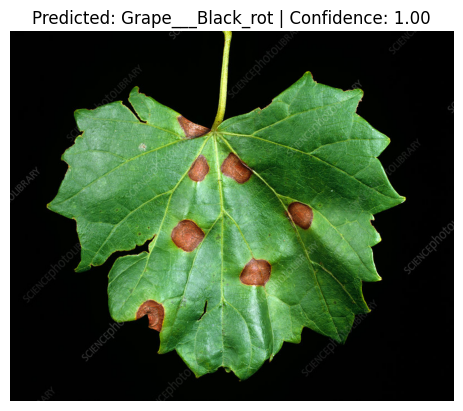

In [24]:
# Function for image prediction
def predict_image(img_path, model, img_size):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add dimension for batch size
    img_array /= 255.0  # Normalization
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction)  # Predicted class
    confidence = prediction[0][pred_class]
    return pred_class, confidence

# Function for image prediction
def display_image_and_prediction(img_path, pred_class, confidence, class_names):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[pred_class]} | Confidence: {confidence:.2f}')
    plt.show()

# Make a predict
img_path = '/content/test2.jpg'
pred_class, confidence = predict_image(img_path, model, img_size)

# List of class names in the model
class_names = list(test_generator.class_indices.keys())

# Display images and prediction results
display_image_and_prediction(img_path, pred_class, confidence, class_names)


11. Saved Model

In [25]:
# Save the fine-tuned model
model.save('Final Grape MobileNetV2 model.h5')